In [481]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import networkx as nx
%matplotlib inline

import sys
sys.path.append("/home/jonas/phd/NanoNets/src/")
sys.path.append("/home/j/j_mens07/phd/NanoNets/src/")
sys.path.append("/mnt/c/Users/jonas/Desktop/phd/NanoNets/src/")

import nanonets_utils
import nanonets

from scipy.signal import savgol_filter, correlate
from scipy.optimize import curve_fit

def scale_landscape(arr):
    return np.round((arr - np.min(arr,axis=0))/(np.max(arr,axis=0)-np.min(arr,axis=0)),2)

def autocorrelation(x : np.array, y : np.array, lags : int):

    return [np.corrcoef(x, y)[0,1] if l==0 else np.corrcoef(x[:-l], y[l:])[0,1] for l in range(lags)]

def exp_decline_cv(arr, min_val=0, max_pos=0, final_pos=0):

    start_val   = np.mean(arr[:100])

    if max_pos==0:
        max_pos     = np.where(arr == np.max(arr))[0][0]
    arr         = arr - start_val
    if final_pos==0:
        final_pos   = np.where(arr[max_pos:] < min_val)[0][0]
    arr         = arr[max_pos:final_pos+max_pos]
    arr         = arr/np.sum(arr)
    cv          = np.std(arr)/np.mean(arr)

    return cv

def fit_exp_decline(time_steps, arr, min_val=0):
    
    start_val   = np.mean(arr[:100])
    max_pos     = np.where(arr == np.max(arr))[0][0]
    arr         = arr - start_val
    final_pos   = np.where(arr[max_pos:] < min_val)[0][0]
    arr         = np.log(arr[max_pos:final_pos+max_pos])
    vals        = np.polyfit(time_steps[max_pos:final_pos+max_pos], arr, 1)

    return -1/vals[0]

### Network Plot

In [417]:
# topology_parameter = {
#     "Nx"    :   7,
#     "Ny"    :   7,
#     "Nz"    :   1,
#     "e_pos" :   [[0,0,0],[6,6,0]]
# }

# sim_class = nanonets.simulation('cubic', topology_parameter)

# with plt.style.context(["science","bright", "grid"]):
#     fig     = plt.figure(dpi=200)
#     ax      = fig.add_subplot()
#     fig, ax = nanonets_utils.display_network(sim_class, fig=fig, ax=ax, node_size=200)
#     fig.savefig("plots/network.png", transparent=True)
#     fig.savefig("plots/network.svg", transparent=True)

### Relaxation Time $\tau$
- Fit exp function to output electric current response

In [500]:
Nmin        = 3
Nmax        = 12
N_vals      = Nmax-Nmin+1
dic_base    = {i : pd.read_csv(f"../1I_1O/data/Nx={i}_Ny={i}_Nz=1_Ne=8.csv") for i in range(Nmin, Nmax+1)}
step_size   = 1e-10
time_steps  = step_size*np.arange(len(dic_base[3]))*1e9

In [502]:
dic_R       = {}
rad_vals    = [5, 10,15, 20]#,25,30,35,40]

for seed in range(10):
    
    dic_R[seed] = {R_val : pd.read_csv(f"../1I_1O_radius/data/Nx=7_Ny=7_Nz=1_Ne=8_{R_val}_{seed}.csv") if R_val != 10 else pd.read_csv(f"../1I_1O/data/Nx=7_Ny=7_Nz=1_Ne=8.csv") for R_val in rad_vals}

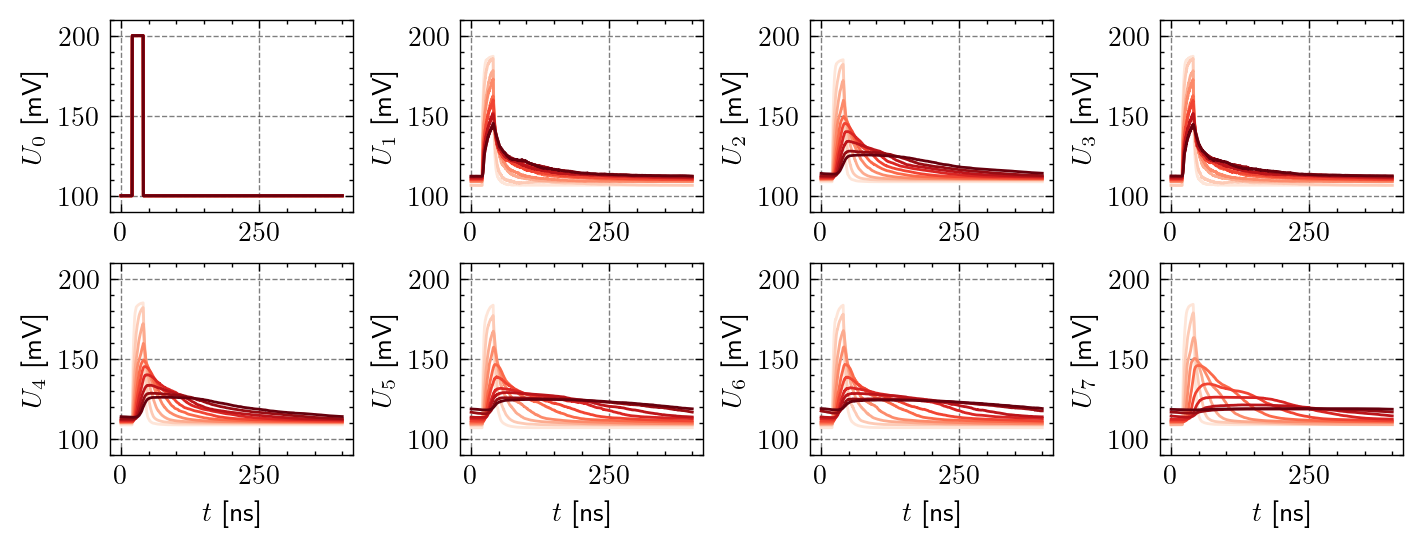

In [503]:
cmap = plt.get_cmap('Reds')

with plt.style.context(["science","bright", "grid"]):

    fig = plt.figure(dpi=200, layout='constrained')
    fig.set_figwidth(fig.get_figwidth()*2)

    for j in range(8):

        ax  = fig.add_subplot(2,4,j+1)

        for i, (key, df_base) in enumerate(dic_base.items()):

            ax.plot(time_steps, df_base[f'E{j}']*1000, c=cmap((i+1)/(len(dic_base.keys()))), label=f'${key}$ x ${key}$')
            ax.set_ylim(90,210)
        
        ax.set_ylabel(f"$U_{j}$ [mV]")
        
        if j >= 4:
            ax.set_xlabel("$t$ [ns]")

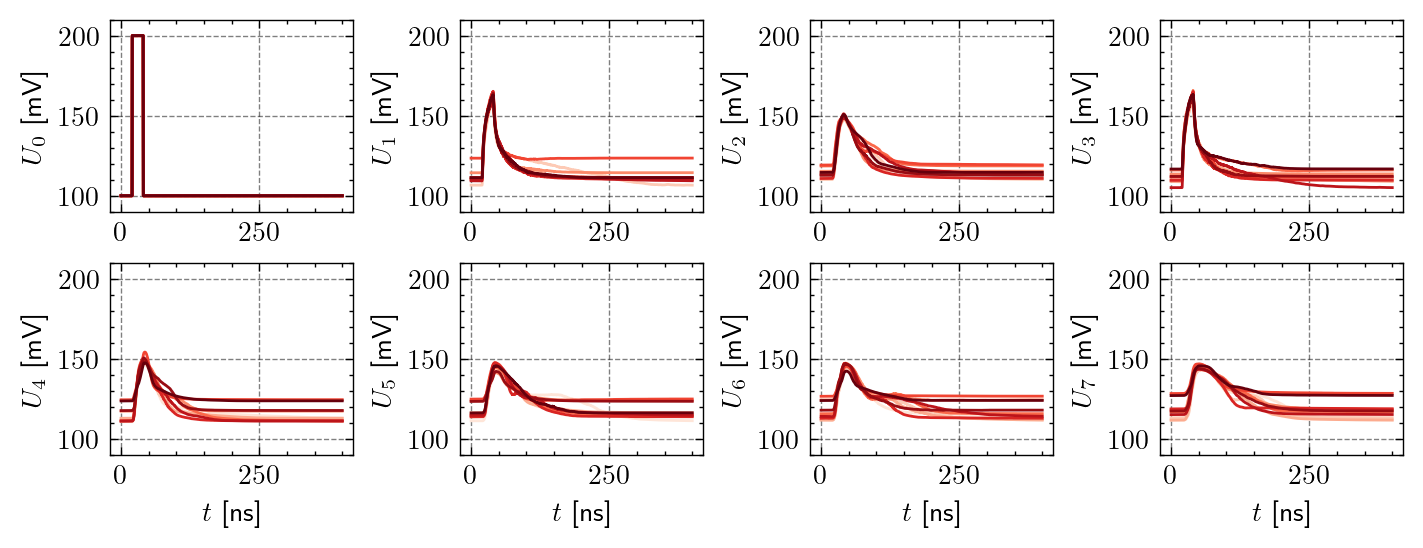

In [505]:
cmap = plt.get_cmap('Reds')

with plt.style.context(["science","bright", "grid"]):

    fig = plt.figure(dpi=200, layout='constrained')
    fig.set_figwidth(fig.get_figwidth()*2)

    for j in range(8):

        ax  = fig.add_subplot(2,4,j+1)

        for i, (key, df_base) in enumerate(dic_R.items()):

            ax.plot(time_steps, df_base[20][f'E{j}']*1000, c=cmap((i+1)/(len(dic_base.keys()))), label=f'${key}$ x ${key}$')
            ax.set_ylim(90,210)
        
        ax.set_ylabel(f"$U_{j}$ [mV]")
        
        if j >= 4:
            ax.set_xlabel("$t$ [ns]")

In [506]:
min_val = 5e-4
cvs     = np.zeros(shape=(7,N_vals))

for i, n in enumerate(dic_base.keys()):
    for j in range(7):
        arr         = dic_base[n][f'E{j+1}'].values
        cv          = exp_decline_cv(arr, min_val, 400)
        cvs[j,i]    = cv

cv_df           = pd.DataFrame(cvs)
cv_df.columns   = np.arange(Nmin, Nmax+1)**2
cv_df

/home/j/j_mens07/.local/lib/python3.11/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/j/j_mens07/.local/lib/python3.11/site-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/j/j_mens07/.local/lib/python3.11/site-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/j/j_mens07/.local/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/j/j_mens07/.local/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,9,16,25,36,49,64,81,100,121,144
0,1.587720,1.990037,1.377372,1.410183,1.331102,1.273604,1.169205,1.255117,1.127460,1.055956
1,1.692404,1.623592,1.338625,1.345009,1.263600,1.242775,1.082405,0.853990,0.707955,0.608280
2,1.553009,1.963608,1.401589,1.432560,1.333129,1.309972,1.192888,1.281885,1.107739,1.038890
3,1.688235,1.651780,1.367138,1.358218,1.256525,1.243631,1.045619,0.861615,0.704913,0.605541
4,1.648778,1.664281,1.584325,1.441630,1.120153,0.920675,0.679491,0.553802,0.402530,0.378335
5,1.638824,1.568755,1.597239,1.424732,1.120069,0.937970,0.692172,0.540937,0.398573,0.383157
6,1.639312,2.288672,1.732222,1.249841,1.001709,0.836022,0.549781,NaN,NaN,NaN


In [507]:
min_val = 5e-4
cvs     = np.zeros(shape=(10*7,len(rad_vals)))

for r, rad_val in enumerate(rad_vals):
    vals = []
    for seed in range(10):
        for e in range(7):
            arr         = dic_R[seed][rad_val][f'E{e+1}'].values
            cv          = exp_decline_cv(arr, min_val, 400)
            vals.append(cv)
    cvs[:,r] = vals

cv_df_rad           = pd.DataFrame(cvs)
cv_df_rad.columns   = rad_vals
cv_df_rad

,5,10,15,20
0,1.363037,1.331102,1.551582,1.500285
1,1.443840,1.263600,0.914854,1.286455
2,1.531644,1.333129,1.327199,1.419746
3,1.314863,1.256525,1.300513,1.317566
4,1.346228,1.120153,0.824385,0.745930
...,...,...,...,...
65,1.421060,1.333129,1.438319,1.068115
66,1.348001,1.256525,1.373474,1.177399
67,0.967634,1.120153,0.959206,0.849707
68,1.265858,1.120069,1.203682,0.799811


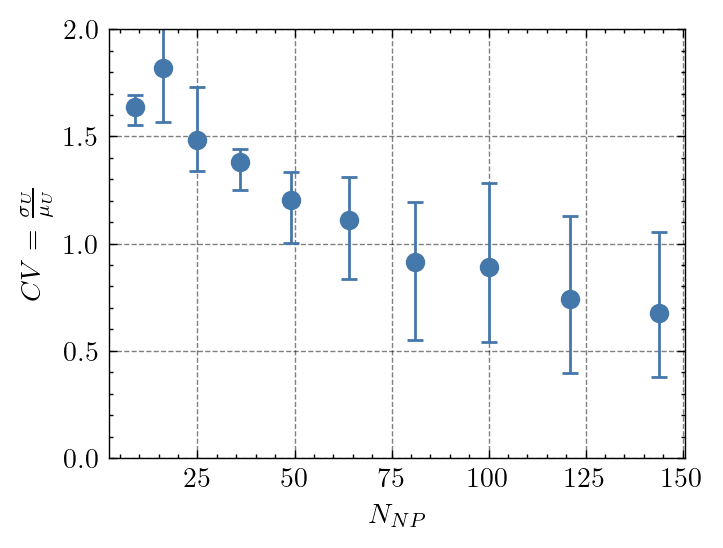

In [508]:
x_val   = np.arange(Nmin, Nmax+1)**2
y_val   = cv_df.mean().values
low     = cv_df.min().values
high    = cv_df.max().values

with plt.style.context(["science","bright", "grid"]):

    fig = plt.figure(dpi=200, layout='constrained')
    ax  = fig.add_subplot()
    ax.errorbar(x=x_val, y=y_val, yerr=(y_val-low,high-y_val), capsize=3, marker='o', ls='')

    ax.set_xlabel("$N_{NP}$")
    ax.set_ylabel("$CV = \\frac{\sigma_U}{\mu_U}$")
    ax.set_ylim(0.,2)

/tmp/ipykernel_3208/3025144034.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title='$N_{NP} = 49$, $r_1 = 10$ nm')


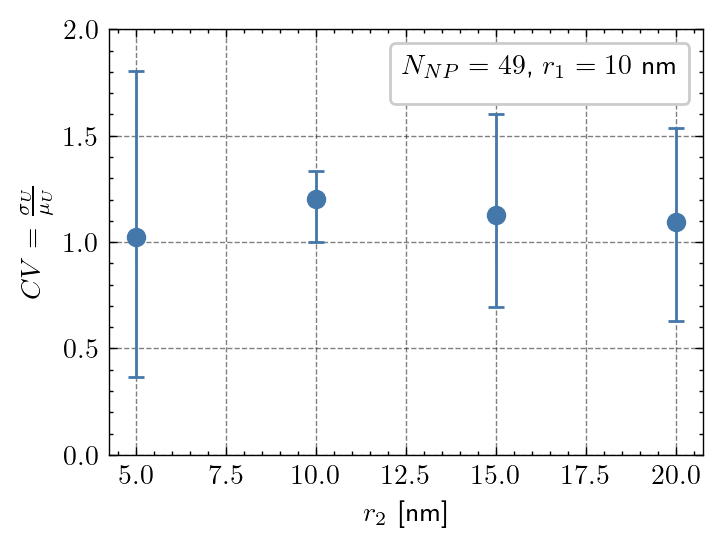

In [509]:
x_val   = rad_vals
y_val   = cv_df_rad.mean().values
low     = cv_df_rad.min().values
high    = cv_df_rad.max().values

with plt.style.context(["science","bright", "grid"]):

    fig = plt.figure(dpi=200, layout='constrained')
    ax  = fig.add_subplot()
    ax.errorbar(x=x_val, y=y_val, yerr=(y_val-low,high-y_val), capsize=3, marker='o', ls='')

    ax.set_xlabel("$r_2$ [nm]")
    ax.set_ylabel("$CV = \\frac{\sigma_U}{\mu_U}$")
    ax.set_ylim(0., 2)
    ax.legend(title='$N_{NP} = 49$, $r_1 = 10$ nm')

In [510]:
min_val = 5e-4
tau     = np.zeros(shape=(7,N_vals))

for i, n in enumerate(dic_base.keys()):
    for j in range(7):
        try:
            arr         = dic_base[n][f'E{j+1}'].values
            cv          = fit_exp_decline(time_steps, arr, min_val)
            tau[j,i]    = cv
        except:
            tau[j,i]    = None
            
tau_df          = pd.DataFrame(tau)
tau_df.columns  = np.arange(Nmin, Nmax+1)**2
tau_df

,9,16,25,36,49,64,81,100,121,144
0,6.209177,99.034453,20.473549,41.752802,59.351088,73.872390,84.812717,90.184403,74.973213,70.664910
1,5.595070,10.893182,15.145342,30.190527,47.226371,66.411855,69.252186,77.475264,98.785786,106.641785
2,5.907256,102.793405,21.230531,44.920751,59.668929,75.695223,85.077848,92.515261,72.696910,68.351978
3,5.589524,11.577750,15.369746,30.551213,47.310961,65.756629,66.941075,78.376958,98.984397,108.674479
4,8.736608,18.055576,35.804448,58.155248,61.104604,73.700979,85.759125,112.455759,181.095455,156.921255
5,8.536045,15.862970,36.563764,55.916836,62.229429,75.919281,86.051204,110.027114,160.629578,159.664400
6,6.188159,47.413882,52.074471,37.542899,49.943743,66.792673,93.170476,120.141745,124.211055,1241.950770


In [513]:
min_val = 5e-4
tau     = np.zeros(shape=(10*7,len(rad_vals)))

for r, rad_val in enumerate(rad_vals):
    vals = []
    for seed in range(10):
        for e in range(7):
            try:
                arr         = dic_R[seed][rad_val][f'E{e+1}'].values
                cv          = fit_exp_decline(time_steps, arr, min_val)
                vals.append(cv)
            except:
                vals.append(None)

    tau[:,r] = vals

tau_df_rad           = pd.DataFrame(tau)
tau_df_rad.columns   = rad_vals
tau_df_rad

,5,10,15,20
0,30.490519,59.351088,97.765301,73.899193
1,65.302465,47.226371,96.521098,98.764437
2,63.924058,59.668929,71.277857,76.799947
3,55.868432,47.310961,52.263880,90.910454
4,117.446832,61.104604,72.373166,77.231274
...,...,...,...,...
65,46.663072,59.668929,43.970794,52.732981
66,72.766613,47.310961,58.337389,32.177785
67,94.830457,61.104604,76.513458,39.083675
68,82.963176,62.229429,44.550706,39.264004


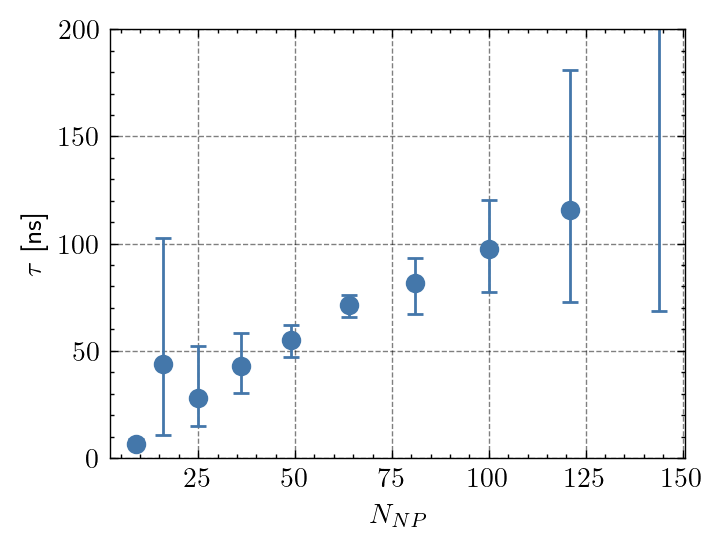

In [517]:
x_val   = np.arange(Nmin, Nmax+1)**2
y_val   = tau_df.mean().values
low     = tau_df.min().values
high    = tau_df.max().values

with plt.style.context(["science","bright", "grid"]):

    fig = plt.figure(dpi=200, layout='constrained')
    ax  = fig.add_subplot()
    ax.errorbar(x=x_val, y=y_val, yerr=(y_val-low,high-y_val), capsize=3, marker='o', ls='')

    ax.set_xlabel("$N_{NP}$")
    ax.set_ylabel("$\\tau$ [ns]")

    ax.set_ylim(0,200)

/tmp/ipykernel_3208/118034991.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title='$N_{NP} = 49$, $r_1 = 10$ nm')


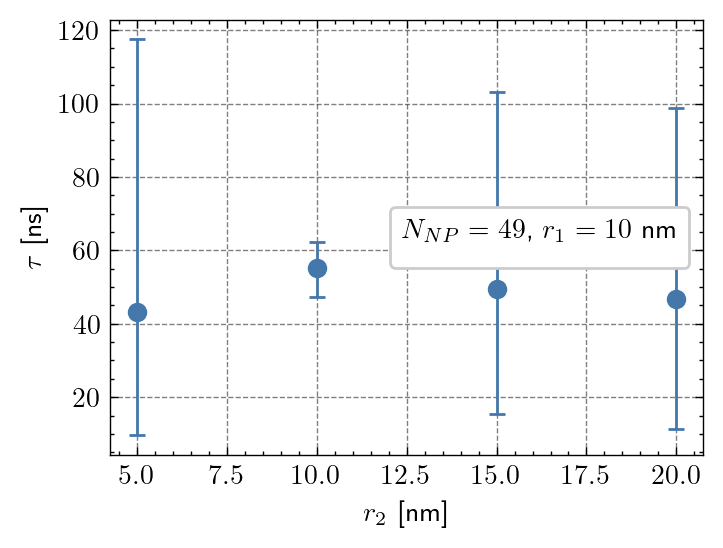

In [515]:
x_val   = rad_vals
y_val   = tau_df_rad.mean().values
low     = tau_df_rad.min().values
high    = tau_df_rad.max().values

with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=200, layout='constrained')
    ax  = fig.add_subplot()
    ax.errorbar(x=x_val, y=y_val, yerr=(y_val-low,high-y_val), capsize=3, marker='o', ls='')

    ax.set_xlabel("$r_2$ [nm]")
    ax.set_ylabel("$\\tau$ [ns]")
    ax.legend(title='$N_{NP} = 49$, $r_1 = 10$ nm')

---

/tmp/ipykernel_14931/3198140537.py:10: RuntimeWarning: divide by zero encountered in log
  y_new   = np.log(dic_base[N]['Current'].values - np.mean(dic_base[N]['Current'].values[:50]))
/tmp/ipykernel_14931/3198140537.py:10: RuntimeWarning: invalid value encountered in log
  y_new   = np.log(dic_base[N]['Current'].values - np.mean(dic_base[N]['Current'].values[:50]))


array([[-3.03535078e-01,  6.60582180e+00],
       [-1.30957573e-01,  1.36190884e+00],
       [-4.72728751e-02, -1.43948174e+00],
       [-9.25281942e-03, -2.92690817e+00],
       [ 2.89176033e-03, -3.51076901e+00],
       [ 2.81382262e-02, -5.19437774e+00],
       [ 6.72361627e-02, -8.98955096e+00],
       [            nan,             nan],
       [ 4.90179213e-02, -1.21464684e+01],
       [ 1.54570489e-02, -1.10973489e+01]])

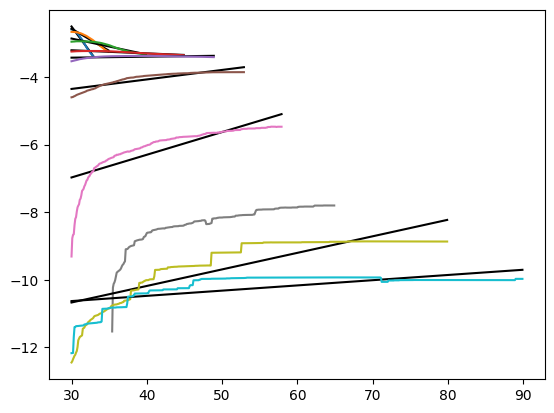

In [5]:
fits    = []
x_start = 300
x_ends  = [330,350,400,450,490,530,580,650,800,900]

for i, N in enumerate(range(Nmin,Nmax+1)):

    x_new   = time_vals
    x_end   = x_ends[i]
    
    y_new   = np.log(dic_base[N]['Current'].values - np.mean(dic_base[N]['Current'].values[:50]))
    vals    = np.polyfit(x_new[x_start:x_end], y_new[x_start:x_end], 1)
    fits.append(vals)
    plt.plot(x_new[x_start:x_end], vals[0]*x_new[x_start:x_end] + vals[1], 'black')
    plt.plot(x_new[x_start:x_end], y_new[x_start:x_end])
    
fits = np.array(fits)
np.savetxt("fit_params_uniform.csv", fits)
fits

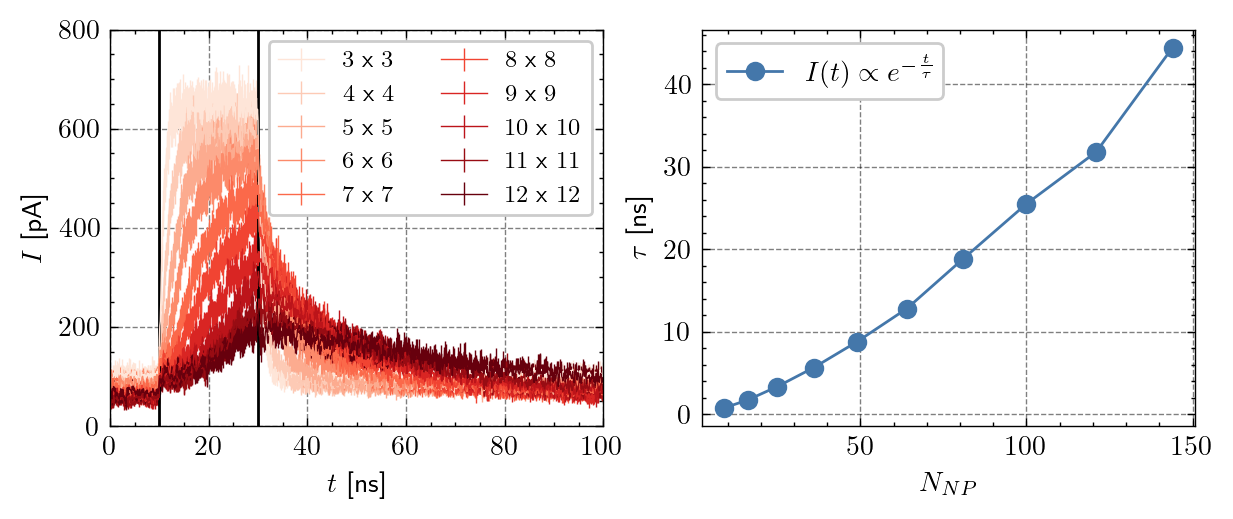

In [10]:
cmap = plt.get_cmap('Reds')

with plt.style.context(["science","bright", "grid"]):

    fig = plt.figure(dpi=200)
    fig.set_figwidth(fig.get_figwidth()*2)
    ax  = fig.add_subplot(1,2,1)

    for i, (key, df_base) in enumerate(dic_base.items()):
        ax.errorbar(time_vals, df_base['Current'], df_base['Error'], marker='', markevery=2, lw=0.5, c=cmap((i+1)/(len(dic_base.keys()))), label=f'${key}$ x ${key}$')
    
    ax.set_ylabel('$I$ [pA]')
    ax.set_xlabel('$t$ [ns]')
    ax.legend(fontsize='small', ncol=2)
    ax.set_xlim(0,100)
    ax.set_ylim(0,800)

    ax.vlines(10,0,800, 'black')
    ax.vlines(30,0,800, 'black')
    # ax.set_yscale('log')

    ax  = fig.add_subplot(1,2,2)
    ax.plot(np.array(list(dic_base.keys()))**2, -1/fits[:,0], 'o-', label='$I(t) \propto e^{-\\frac{t}{\\tau}}$')
    ax.set_ylabel('$\\tau$ [ns]')
    ax.set_xlabel('$N_{NP}$')
    # ax.set_ylim(0,1.2)
    ax.legend()

    # fig.savefig("plots/I_O.png")

### FFT of Output Response:
- Small Frequencies = Slow transient part

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


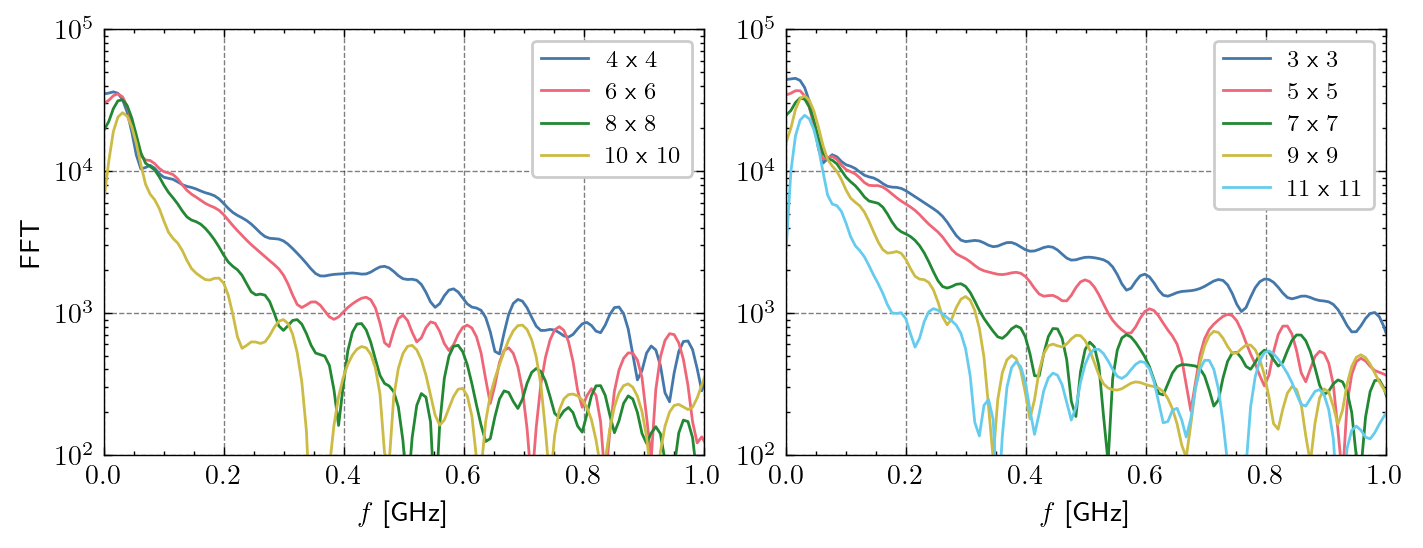

In [86]:
with plt.style.context(["science","bright", "grid"]):

    fig = plt.figure(dpi=200, layout='constrained')
    fig.set_figwidth(fig.get_figwidth()*2)
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)

    for N in range(3,12):

        signal  = dic_base[N]['Current'].values
        dt      = 1e-10
        xf, yf  = nanonets_utils.fft(signal-np.mean(signal), dt, n_padded=8192)

        if N % 2 == 0:
            ax1.plot(xf, yf, label=f'${N}$ x ${N}$')
        else:
            ax2.plot(xf, yf, label=f'${N}$ x ${N}$')
        
        ax1.set_xlim(0,1)
        ax2.set_xlim(0,1)
        ax1.set_ylim(1e2,1e5)
        ax2.set_ylim(1e2,1e5)
        
        ax1.set_yscale('log')
        ax2.set_yscale('log')

        ax1.set_xlabel("$f$ [GHz]")
        ax2.set_xlabel("$f$ [GHz]")
        
        ax1.set_ylabel('FFT')

        ax1.legend(fontsize='small')
        ax2.legend(fontsize='small')

### Charge Redistribution Analysis
- Neuron time scales

In [11]:
def multiplot_observable_based_on_network(x_vals : pd.DataFrame, y_vals : pd.DataFrame, N : int,
                                          fig_scale=(1.5,1.5), x_lim=None, y_lim=None, y_label='y',
                                          x_label='x', log_x=False, log_y=False, style_context=["science","bright","grid"]):
    
    if type(x_vals) == type(np.array([])):

        x_vals_new = pd.DataFrame()

        for col in y_vals.columns:

            x_vals_new[col] = x_vals
    
        x_vals = x_vals_new

    with plt.style.context(style_context):
        
        fig, axs    = plt.subplots(ncols=N, nrows=N, layout='constrained')
        width       = fig.get_figwidth()
        fig.set_figwidth(width*fig_scale[0])
        fig.set_figheight(width*fig_scale[1])

        if x_lim == None:
            x_lim = [x_vals.min().min(), x_vals.max().max()]

        if y_lim == None:
            y_lim = [y_vals.min().min(), y_vals.max().max()]

        i = 0

        for row in np.arange((N-1),-1,-1):
            
            for col in range(0,N):

                axs[row,col].plot(x_vals.loc[:,i], y_vals.loc[:,i])
                axs[row,col].set_xlim(x_lim[0],x_lim[1])
                axs[row,col].set_ylim(y_lim[0],y_lim[1])

                if i % N != 0:
                    axs[row,col].set_yticklabels("")
                else:    
                    axs[row,col].set_ylabel(y_label)

                if (i > N-1):
                    axs[row,col].set_xticklabels("")
                else:
                    axs[row,col].set_xlabel(x_label)

                if log_x:
                    axs[row,col].set_xscale('log')

                if log_y:
                    axs[row,col].set_yscale('log')

                i += 1

    return fig, axs

In [12]:
dic_states  = {N : pd.read_csv(f"../1I_1O/data/mean_state_Nx={N}_Ny={N}_Nz=1_Ne=2.csv", names=np.arange(0,N*N)).drop(0) for N in range(3,13)}
states7     = dic_states[7].copy()

/home/j/j_mens07/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  
/home/j/j_mens07/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  
/home/j/j_mens07/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  
/home/j/j_mens07/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  
/home/j/j_mens07/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  
/home/j/j_mens07/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  
/home/j/j_mens07/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  
/home/j/j_mens07/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: inva

array([10.04476182,  7.87115767,  8.02917574,  8.68579806,  8.33970516,
       11.7792408 ,  7.46146192,  6.46610293,  7.98511521,  9.0258896 ,
        8.75174727,  9.19255886,  8.22817289,  9.496502  ,  8.46075544,
        8.12472896,  8.99967204,  8.37793585,  8.51938411,  9.19345008,
        9.31918476,  8.40377461,  9.0865622 ,  8.2839759 ,  8.56274393,
        9.41785466, 10.12269611, 10.00738808,  9.23459701,  9.39592929,
        8.91037366,  9.58694404, 10.15401553,  9.75977609, 11.17578647,
        8.77152869,  9.3529278 ,  9.71921972,  9.72163252, 10.3239689 ,
        8.71651947,  8.66375138, 11.32603871,  7.77215067,  9.90376863,
       10.40093747, 10.45856518,  7.70839961, 11.48439797])

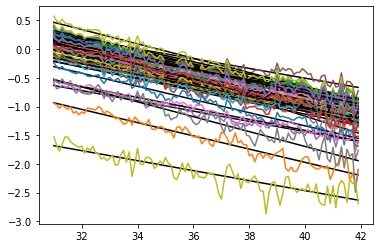

In [13]:
fits_s  = []
x_start = 310
x_end   = 420

for i, col in enumerate(states7.columns):

    x_new   = time_vals    
    y_new   = np.log(states7[col].values - np.mean(states7[col].values[:50]))
    vals    = np.polyfit(x_new[x_start:x_end], y_new[x_start:x_end], 1)
    fits_s.append(-1/vals[0])
    plt.plot(x_new[x_start:x_end], vals[0]*x_new[x_start:x_end] + vals[1], 'black')
    plt.plot(x_new[x_start:x_end], y_new[x_start:x_end])
fits_s = np.array(fits_s)
fits_s

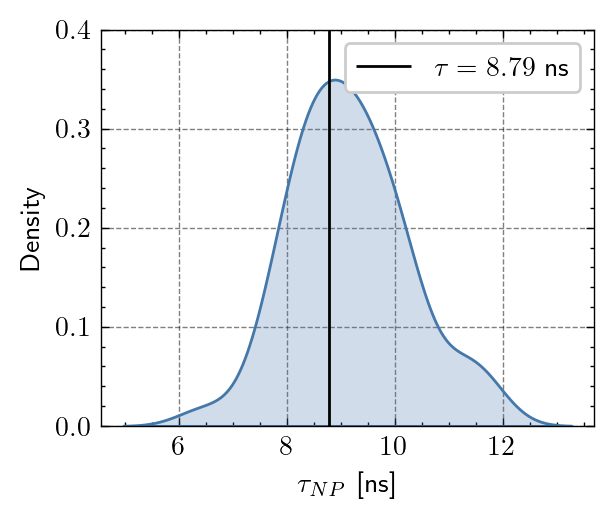

In [16]:
tau_7 = np.round(-1/fits[4,0],2)

with plt.style.context(["science","bright", "grid"]):

    fig = plt.figure(dpi=200)
    fig.set_figwidth(fig.get_figwidth()*2)
    ax  = fig.add_subplot(1,2,1)
    ax  = sns.kdeplot(fits_s, ax=ax, fill=True)
    ax.vlines(tau_7, ymin=0, ymax=0.5, color='black', label=f'$\\tau = {tau_7}$ ns')
    ax.legend()
    ax.set_ylim(0,0.4)
    ax.set_xlabel('$\\tau_{NP}$ [ns]')

    fig.savefig("plots/node_signal_time_scales.png")

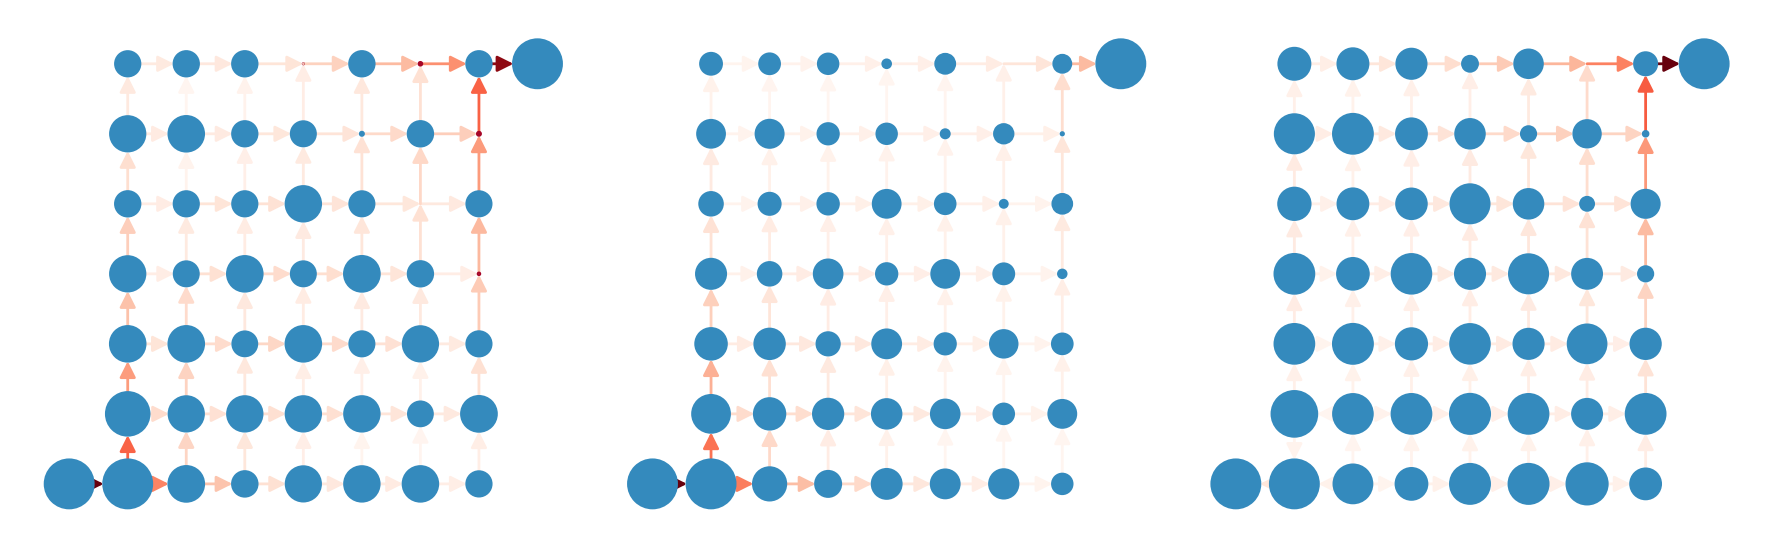

In [184]:
N                   = 7
topology_parameter  = {
    "Nx"    :   N,
    "Ny"    :   N,
    "Nz"    :   1,
    "e_pos" :   [[0,0,0],[N-1,N-1,0]]
}

sim_class   = nanonets.simulation('cubic', topology_parameter)

with plt.style.context(["science","bright", "grid"]):

    fig     = plt.figure(dpi=200, layout='constrained')
    fig.set_figwidth(fig.get_figwidth()*2.5)
    
    ax1     = fig.add_subplot(1,3,1)
    ax2     = fig.add_subplot(1,3,2)
    ax3     = fig.add_subplot(1,3,3)
    
    sim_class   = nanonets.simulation('cubic', topology_parameter)
    fig, ax1    = nanonets_utils.display_network_currents(path=f"../1I_1O/data/net_currents_Nx={N}_Ny={N}_Nz=1_Ne=2.csv", row=[0,100], N_electrodes=2, pos=sim_class.pos, charge_landscape=True, fig=fig, ax=ax1)
    sim_class   = nanonets.simulation('cubic', topology_parameter)
    fig, ax2    = nanonets_utils.display_network_currents(path=f"../1I_1O/data/net_currents_Nx={N}_Ny={N}_Nz=1_Ne=2.csv", row=[100,200], N_electrodes=2, pos=sim_class.pos, charge_landscape=True, fig=fig, ax=ax2)
    sim_class   = nanonets.simulation('cubic', topology_parameter)
    fig, ax3    = nanonets_utils.display_network_currents(path=f"../1I_1O/data/net_currents_Nx={N}_Ny={N}_Nz=1_Ne=2.csv", row=[300,400], N_electrodes=2, pos=sim_class.pos, charge_landscape=True, fig=fig, ax=ax3)

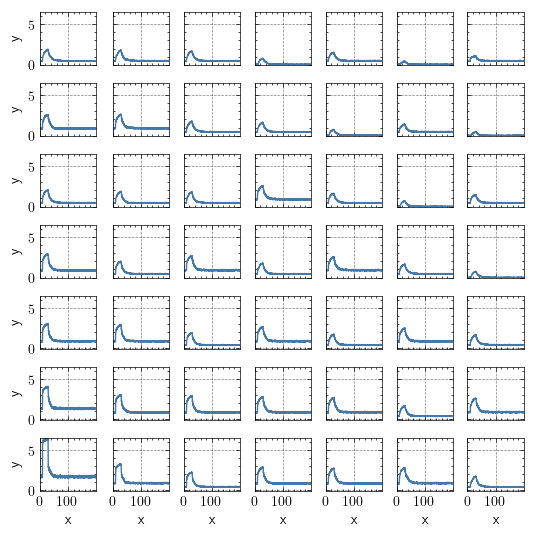

In [92]:
fig, ax = multiplot_observable_based_on_network(time_vals, dic_states[N], N)

<Axes: >

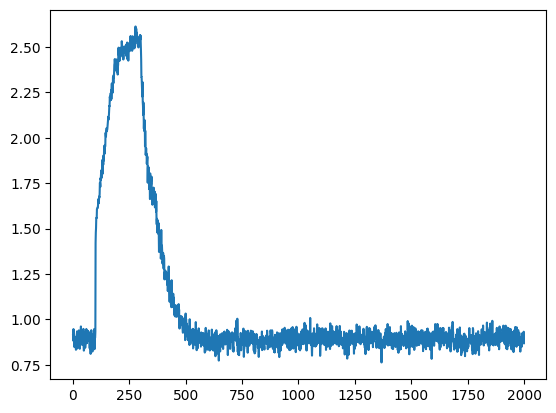

In [54]:
states7[35].plot()

In [27]:
dic_currents = {N : pd.read_csv(f"../1I_1O/data/net_currents_Nx={N}_Ny={N}_Nz=1_Ne=2.csv") for N in range(3,13)}

In [140]:
N_e = 2

original_pos    = sim_class.pos
adjusted_pos    = {key + N_e: value for key, value in original_pos.items()}
negative_keys   = sorted([key for key in original_pos.keys() if key < 0])
negative_keys_r = list(reversed(negative_keys))

for i, key in enumerate(negative_keys):
    adjusted_pos[i] = original_pos[negative_keys_r[i]]

In [158]:
N   = 9
N_e = 2
df  = dic_currents[N].copy()*1e9
G   = nx.DiGraph()

junctions           = [eval(col) for col in df.columns]
junctions_weights   = [10*np.log(val+1.1) for val in df.mean().to_list()]

G.add_nodes_from(np.arange(0,N*N+N_e))
G.add_edges_from(junctions)

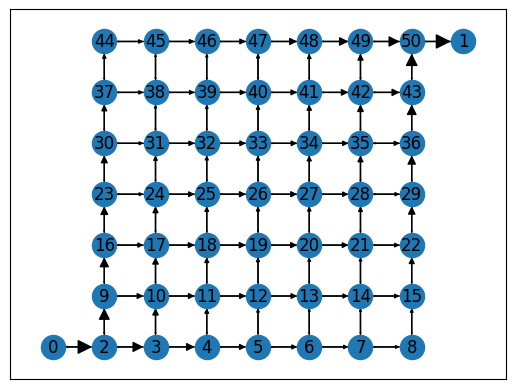

In [159]:
# pos = nx.kamada_kawai_layout(G)
nx.draw_networkx(G, arrowsize=junctions_weights, pos=adjusted_pos)

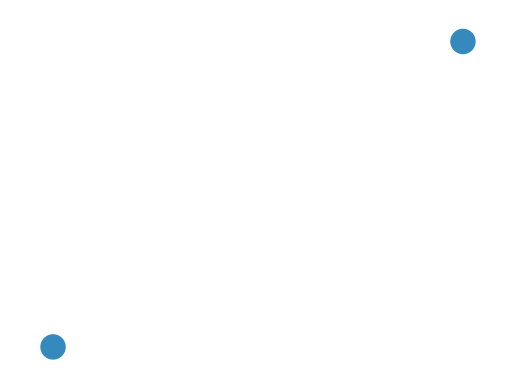

In [141]:
N                   = 3
topology_parameter  = {
    "Nx"    :   N,
    "Ny"    :   N,
    "Nz"    :   1,
    "e_pos" :   [[0,0,0],[N-1,N-1,0]]
}

sim_class   = nanonets.simulation('cubic', topology_parameter)
fig, ax     = nanonets_utils.display_network_currents(f"../1I_1O/data/net_currents_Nx={N}_Ny={N}_Nz=1_Ne=2.csv", 'mean', 2, pos=sim_class.pos, charge_landscape=True)

In [ ]:
nanonets_utils.display_network_currents()

In [53]:
sim_class.pos

{0: [0, 0],
 1: [1, 0],
 2: [2, 0],
 3: [3, 0],
 4: [4, 0],
 5: [5, 0],
 6: [6, 0],
 7: [0, 1],
 8: [1, 1],
 9: [2, 1],
 10: [3, 1],
 11: [4, 1],
 12: [5, 1],
 13: [6, 1],
 14: [0, 2],
 15: [1, 2],
 16: [2, 2],
 17: [3, 2],
 18: [4, 2],
 19: [5, 2],
 20: [6, 2],
 21: [0, 3],
 22: [1, 3],
 23: [2, 3],
 24: [3, 3],
 25: [4, 3],
 26: [5, 3],
 27: [6, 3],
 28: [0, 4],
 29: [1, 4],
 30: [2, 4],
 31: [3, 4],
 32: [4, 4],
 33: [5, 4],
 34: [6, 4],
 35: [0, 5],
 36: [1, 5],
 37: [2, 5],
 38: [3, 5],
 39: [4, 5],
 40: [5, 5],
 41: [6, 5],
 42: [0, 6],
 43: [1, 6],
 44: [2, 6],
 45: [3, 6],
 46: [4, 6],
 47: [5, 6],
 48: [6, 6],
 -1: (-1, 0),
 -2: (7, 6)}

NetworkXError: Node 49 has no position.

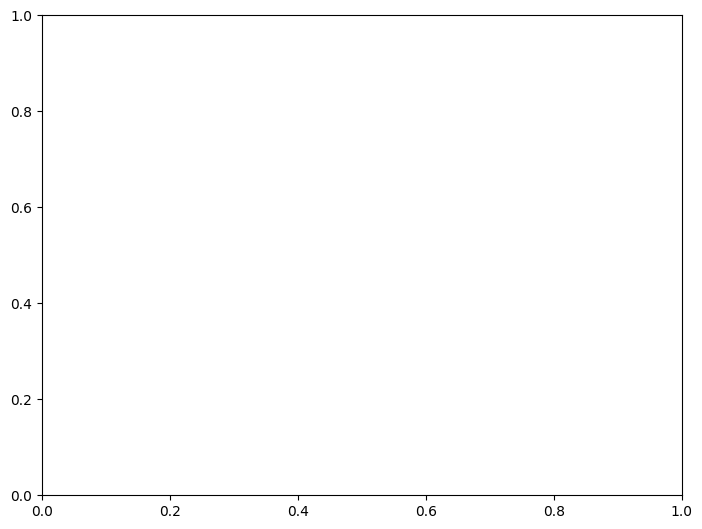

In [52]:
nx.draw(G, pos=sim_class.pos)

In [34]:
Nmin        = 4
Nmax        = 4
small_Rs    = []

for N in range(Nmin,Nmax+1):

    df  = dic_currents[N].copy()*1e9
    G   = nx.DiGraph()


    junctions   = [eval(col) for col in df.columns]
    junctions_w = [j + (1/df.iloc[:,i].mean(),) if (df.iloc[:,i].mean() != 0) else j + (np.inf,) for i, j in enumerate(junctions)]

    G.add_nodes_from(np.arange(0,N*N+2))
    G.add_weighted_edges_from(junctions_w)

    smallest_R_path = nx.shortest_path_length(G, 0, 1, weight='weight')

    small_Rs.append(smallest_R_path)

StopIteration: 

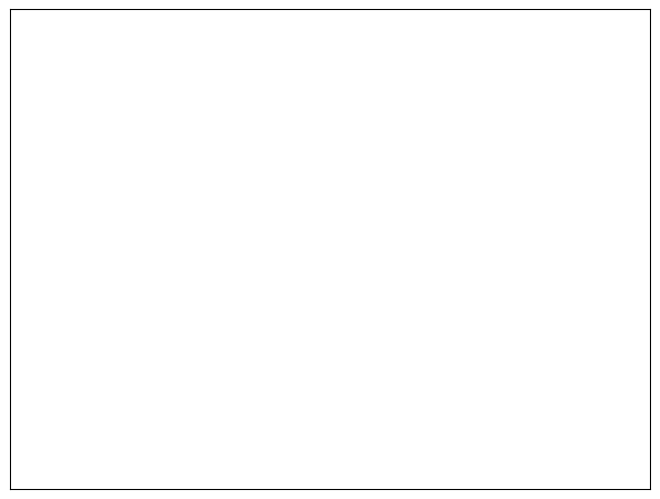

In [36]:
nx.draw(G)

In [239]:
for i, path in enumerate(nx.shortest_simple_paths(G, 0, 1, weight='weight')):
    
    print(path)
    print(nx.path_weight(G=G, path=path, weight='weight'))

    if i > 200:
        break

[0, 2, 3, 7, 8, 12, 16, 17, 1]
1008.8256990258448
[0, 2, 3, 7, 11, 12, 16, 17, 1]
1025.7518260228858
[0, 2, 6, 7, 8, 12, 16, 17, 1]
1080.1071628255775
[0, 2, 6, 7, 11, 12, 16, 17, 1]
1097.0332898226186
[0, 2, 3, 4, 8, 12, 16, 17, 1]
1197.5057703565765
[0, 2, 3, 7, 8, 12, 13, 17, 1]
1227.5395347018432
[0, 2, 3, 7, 11, 12, 13, 17, 1]
1244.4656616988843
[0, 2, 3, 4, 8, 7, 11, 12, 16, 17, 1]
1280.9435975047718
[0, 2, 6, 7, 8, 12, 13, 17, 1]
1298.820998501576
[0, 2, 6, 10, 11, 12, 16, 17, 1]
1309.7585341320696
[0, 2, 6, 7, 11, 12, 13, 17, 1]
1315.7471254986172
[0, 2, 3, 7, 6, 10, 11, 12, 16, 17, 1]
1365.4712678392386
[0, 2, 6, 10, 11, 7, 8, 12, 16, 17, 1]
1389.9165994143093
[0, 2, 6, 7, 3, 4, 8, 12, 16, 17, 1]
1397.283335494447
[0, 2, 3, 4, 8, 12, 13, 17, 1]
1416.2196060325753
[0, 2, 3, 7, 11, 15, 16, 17, 1]
1490.0161233060824
[0, 2, 3, 4, 8, 7, 11, 12, 13, 17, 1]
1499.6574331807703
[0, 2, 6, 10, 11, 12, 13, 17, 1]
1528.4723698080682
[0, 2, 6, 7, 11, 15, 16, 17, 1]
1561.2975871058152
[0, 2,

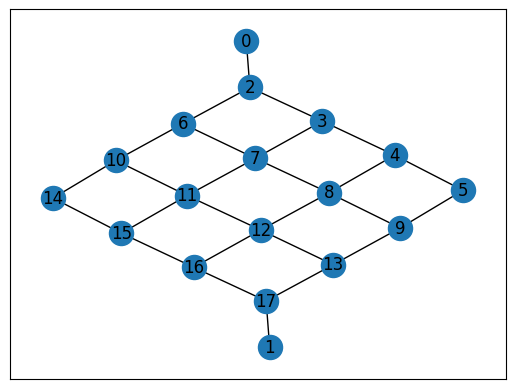

In [240]:
pos = nx.kamada_kawai_layout(G, weight=None)
nx.draw_networkx(G, pos)

In [115]:
# nx.get_edge_attributes(G, 'weight')

In [170]:
nx.shortest_path_length(G, 0, 1, weight='weight')

0.36088077348527203

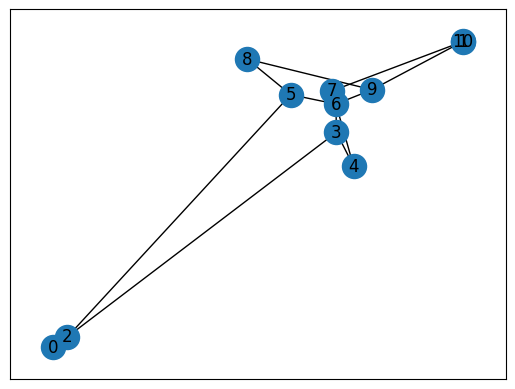

In [169]:
pos     = {N : np.random.uniform(0,1,2) for N in range(0,N*N+2)}
pos[0]  = [0,0]
pos[1]  = [1,1]
pos2    = nx.kamada_kawai_layout(G, pos=pos, center=[0.5,0.5], scale=1)
nx.draw_networkx(G, pos2)

In [9]:
df_landscape = pd.read_csv("../1I_1O/data/mean_state_Nx=3_Ny=3_Nz=1_Ne=2.csv")
df_landscape

,0,1,2,3,4,5,6,7,8
0,0.591803,0.735647,0.006810,0.748661,0.356834,0.362574,0.364078,0.369862,0.371058
1,0.601144,0.703495,0.005361,0.712804,0.368018,0.325291,0.356405,0.366912,0.369811
2,0.611461,0.752021,-0.006045,0.745911,0.362869,0.348473,0.359160,0.372000,0.380709
3,0.598267,0.745620,0.007830,0.745539,0.359539,0.341885,0.355404,0.358215,0.373739
4,0.610440,0.723257,0.000237,0.733940,0.349062,0.344651,0.347557,0.365206,0.357684
...,...,...,...,...,...,...,...,...,...
1994,0.611102,0.735719,0.014143,0.760114,0.366065,0.354691,0.386131,0.384765,0.374379
1995,0.624636,0.783871,0.003577,0.773738,0.356132,0.337651,0.361704,0.375768,0.422427
1996,0.570205,0.682018,-0.001341,0.672758,0.339393,0.321568,0.335198,0.335911,0.352092
1997,0.594041,0.743748,0.017180,0.764351,0.392059,0.340010,0.375050,0.360031,0.375291


In [11]:
R_vals              = [50,100,200,400,800,1600,3200,6400,12800]
results_stat        = {}
states_stat         = {}
# net_currents_stat   = {}

for stat in range(1,11):
    stat = f"r{stat}"
    states          = {}
    # net_currents    = {}
    results         = pd.DataFrame()
    results["t"]    = np.loadtxt("../1I_1O/time.csv")[1:]*10**9
    results["U"]    = pd.read_csv(f"/home/jonas/phd/data/1I_1O_R/R_50/{stat}/Nx=7_Ny=7_Nz=1_Ne=2.csv")['E0']

    for R_val in R_vals:

        results[f"I_R{R_val}"]      = pd.read_csv(f"/home/jonas/phd/data/1I_1O_R/R_{R_val}/{stat}/Nx=7_Ny=7_Nz=1_Ne=2.csv")['Current']
        results[f"uI_R{R_val}"]     = pd.read_csv(f"/home/jonas/phd/data/1I_1O_R/R_{R_val}/{stat}/Nx=7_Ny=7_Nz=1_Ne=2.csv")['Error']
        states[f'R_{R_val}']        = pd.read_csv(f"/home/jonas/phd/data/1I_1O_R/R_{R_val}/{stat}/mean_state_Nx=7_Ny=7_Nz=1_Ne=2.csv")
        # net_currents[f'R_{R_val}']  = pd.read_csv(f"/home/jonas/phd/data/1I_1O_R/R_{R_val}/{stat}/net_currents_Nx=7_Ny=7_Nz=1_Ne=2.csv")
    
    results_stat[stat]  = results
    states_stat[stat]   = states

### Input - Output

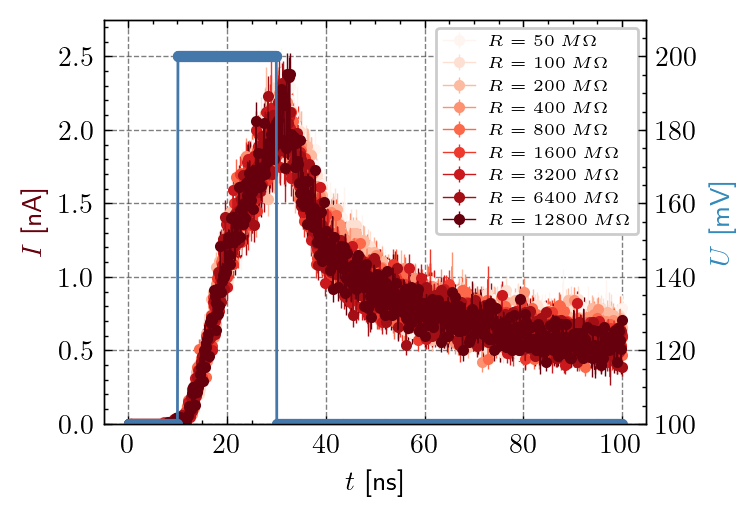

In [ ]:
cmap    = plt.get_cmap('Reds')
R_vals  = [50,100,200,400,800,1600,3200,6400,12800]
stat    = 'r2'

with plt.style.context(["science", "bright", "grid"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()

    for i, R_val in enumerate(R_vals):

        ax.errorbar(results_stat[stat]["t"], results_stat[stat][f'I_R{R_val}']/1000, results_stat[stat][f'uI_R{R_val}']/1000,
                    label=f'$R = {R_val}$ $M\Omega$', c=cmap(i/(len(R_vals)-1)), marker='.', markevery=2, lw=0.5)
        
    ax.legend(ncol=1, fontsize='xx-small')
    ax.set_xlabel("$t$ [ns]")
    ax.set_ylabel("$I$ [nA]", c=cmap(i/(len(R_vals)-1)))
    ax.set_ylim(0,2.75)

    ax2 = ax.twinx()
    ax2.plot(results_stat[stat]["t"], results_stat[stat]['U']*1000, marker='.')
    ax2.grid(False)
    ax2.set_ylabel("$U$ [mV]", c=nanonets_utils.blue_color)
    ax2.set_ylim(100,210)

    fig.savefig(f"1I_1O_R_dis/plots/output_response_{stat}.svg", transparent=True, bbox_inches='tight')

# Vergleich zu exp Funktion

In [ ]:
def model_func(t, A, K, C):
    return A * np.exp(K * t) + C

def fit_exp_linear(t, y, C=0):
    y = y - C
    y = np.log(y)
    K, A_log = np.polyfit(t, y, 1)
    A = np.exp(A_log)
    return A, K

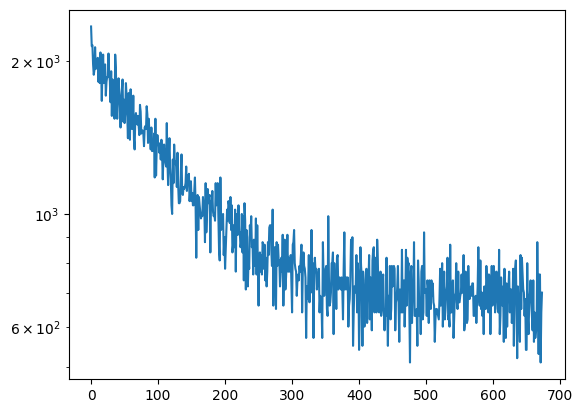

In [ ]:
R_val   = 100
stat    = 'r10'

arr     = results_stat[stat][f'I_R{R_val}'].values
t       = results_stat[stat]["t"]

y       = arr[np.argmax(arr):]
t       = t[np.argmax(arr):]
C       = np.min(y)

# A, K    = fit_exp_linear(t, y, C)

plt.plot(y)
plt.yscale('log')
# plt.plot(model_func(t, A, K, C))

In [ ]:
U_I_auto = {}

for stat in range(1,11):

    stat        = f"r{stat}"
    np_index    = np.arange(49)
    t           = results_stat[stat]["t"].values
    x           = results_stat[stat]["U"].values
    n_lags      = 300
    a_vals      = []

    for R in R_vals:
        a_vals.append(np.round(t[np.argmax(autocorrelation(x,results_stat[stat][f'I_R{R}'].values,n_lags))],2))

    U_I_auto[stat] = a_vals

/home/jonas/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/jonas/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


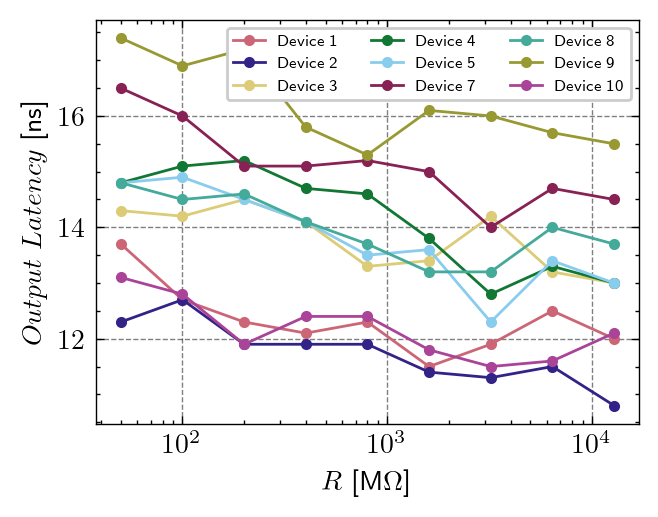

In [ ]:
cmap = plt.get_cmap("Set3")

with plt.style.context(["science","muted", "grid"]):
    
    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()

    for j, stat in enumerate([1,2,3,4,5,7,8,9,10]):

        stat_str = f"r{stat}"
        ax.plot(R_vals, U_I_auto[stat_str], marker='.', label=f'Device {stat}')
    
    ax.set_xscale('log')
    ax.set_ylabel('$Output$ $Latency$ [ns]')
    ax.set_xlabel('$R$ [M$\Omega$]')
    ax.legend(ncol=3, fontsize='xx-small')
    
    fig.savefig(f"1I_1O_R_dis/plots/output_latency.svg", transparent=True, bbox_inches='tight')

### Input - State

In [ ]:
latency_stat = {}

for stat in range(1,11):

    stat        = f"r{stat}"
    np_index    = np.arange(49)
    t           = results_stat[stat]["t"].values
    x           = results_stat[stat]["U"].values
    n_lags      = 300
    latency     = {}

    for key, val in states_stat[stat].items():
        np_vals = []
        for j, i in enumerate(np_index): 
            np_vals.append(np.round(t[np.argmax(autocorrelation(x,val[f"{i}"].values,n_lags))],2))
        latency[key] = np_vals

    latency_stat[stat] = latency

/home/jonas/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/jonas/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


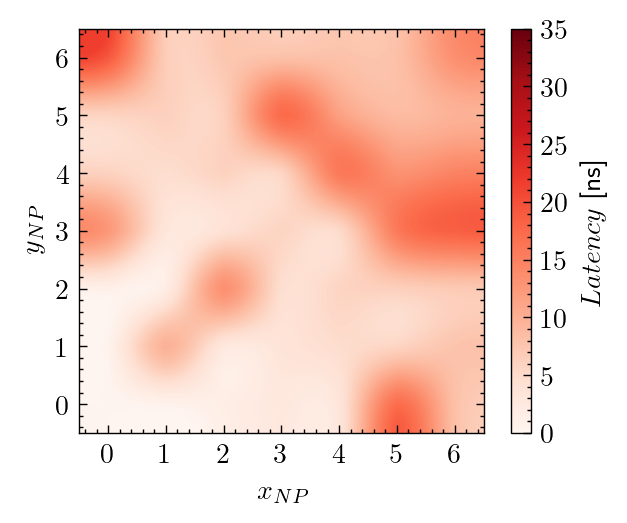

In [ ]:
key     = 'R_100'
stat    = 'r9'

with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()
    im  = ax.imshow(np.array(latency_stat[stat][key]).reshape(7,-1), cmap='Reds', origin='lower', vmin=0, vmax=35, interpolation='Spline16')
    fig.colorbar(im, label='$Latency$ [ns]')
    ax.set_xticks(np.arange(0,7))
    ax.set_yticks(np.arange(0,7))
    ax.set_xlabel("$x_{NP}$")
    ax.set_ylabel("$y_{NP}$")
    fig.savefig(f"1I_1O_R_dis/plots/network_latency_{key}_{stat}.svg", transparent=True, bbox_inches='tight')


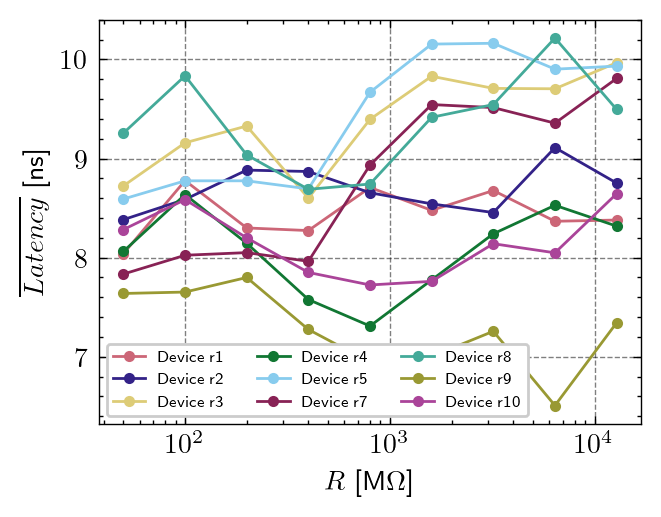

In [ ]:
cmap = plt.get_cmap("Set3")

with plt.style.context(["science","muted", "grid"]):
    
    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()

    for j, stat in enumerate([1,2,3,4,5,7,8,9,10]):

        stat = f"r{stat}"
        ax.plot(R_vals, [np.mean(latency_stat[stat][f'R_{i}']) for i in R_vals], marker='.', label=f'Device {stat}')
    
    ax.set_xscale('log')
    ax.set_ylabel('$\overline{Latency}$ [ns]')
    ax.legend(ncol=3, fontsize='xx-small')
    ax.set_xlabel('$R$ [M$\Omega$]')
    fig.savefig(f"1I_1O_R_dis/plots/avg_network_latency.svg", transparent=True, bbox_inches='tight')

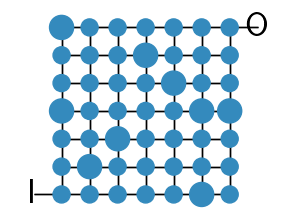

In [ ]:
network_topology    = "cubic"
topology_parameter  = {
    "Nx"    : 7,
    "Ny"    : 7,
    "Nz"    : 1,
    "e_pos" : [[0,0,0],[6,6,0]]
}

np_network_cubic    = nanonets.simulation(network_topology=network_topology, topology_parameter=topology_parameter)
node_size           = np.repeat(150, 51)
seed                = 9
rs                  = np.random.RandomState(seed)

for i in rs.choice(np.arange(1,48), 9, replace=False):
    node_size[i] = 300

fig, ax = nanonets_utils.display_network(np_network_sim=np_network_cubic, node_size=node_size, provide_electrode_labels=["I","O"], font_size=25)
fig.savefig(f"1I_1O_R_dis/plots/network_plot_r{seed}.svg", transparent=True, bbox_inches='tight')

In [ ]:
states_b        = {}
results_b       = pd.DataFrame()
results_b["t"]  = np.loadtxt("1I_1O/time.csv")[1:]*10**9
results_b["U"]  = pd.read_csv(f"1I_1O_R_dis/data/blocked/R_25/Nx=7_Ny=7_Nz=1_Ne=2.csv")['E0']

for R_val in [25,30,35,40,45]:

    results_b[f"I_R{R_val}"]    = pd.read_csv(f"1I_1O_R_dis/data/blocked/R_{R_val}/Nx=7_Ny=7_Nz=1_Ne=2.csv")['Current']
    results_b[f"uI_R{R_val}"]   = pd.read_csv(f"1I_1O_R_dis/data/blocked/R_{R_val}/Nx=7_Ny=7_Nz=1_Ne=2.csv")['Error']
    states_b[f'R_{R_val}']      = pd.read_csv(f"1I_1O_R_dis/data/blocked/R_{R_val}/mean_state_Nx=7_Ny=7_Nz=1_Ne=2.csv")

25
30
35
40
45


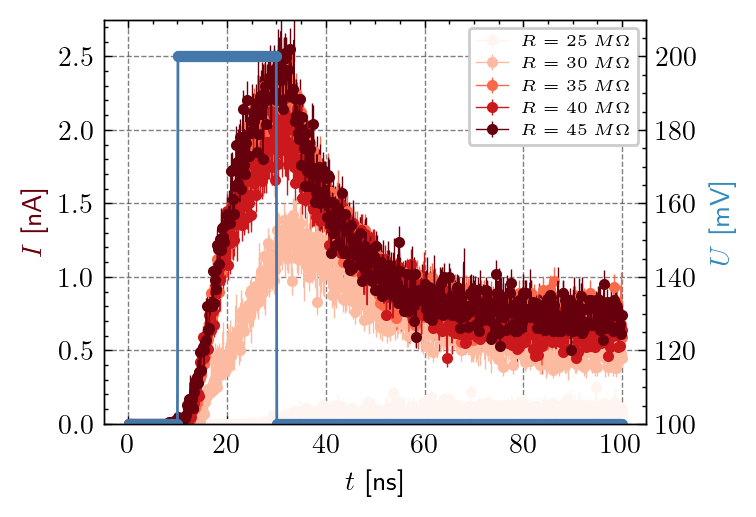

In [ ]:
cmap    = plt.get_cmap('Reds')
R_vals  = [25,30,35,40,45]

with plt.style.context(["science", "bright", "grid"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()

    for i, R_val in enumerate(R_vals):

        ax.errorbar(results_b["t"], results_b[f'I_R{R_val}']/1000, results_b[f'uI_R{R_val}']/1000,
                    label=f'$R = {R_val}$ $M\Omega$', c=cmap(i/(len(R_vals)-1)), marker='.', markevery=2, lw=0.5)
        
    ax.legend(ncol=1, fontsize='xx-small')
    ax.set_xlabel("$t$ [ns]")
    ax.set_ylabel("$I$ [nA]", c=cmap(i/(len(R_vals)-1)))
    ax.set_ylim(0,2.75)

    ax2 = ax.twinx()
    ax2.plot(results_b["t"], results_b['U']*1000, marker='.')
    ax2.grid(False)
    ax2.set_ylabel("$U$ [mV]", c=nanonets_utils.blue_color)
    ax2.set_ylim(100,210)

    fig.savefig(f"1I_1O_R_dis/plots/output_response_blocked.svg", transparent=True, bbox_inches='tight')

# CUT

In [ ]:
np_index        = np.arange(49)
n_lags          = 300
autocorr_sum    = {}

for key, val in states.items():
    np_vals = []
    for j, i in enumerate(np_index): 
        np_vals.append(np.round(np.sum(autocorrelation(x,val[f"{i}"].values,n_lags)),2))
    autocorr_sum[key] = np.sum(np_vals)

In [ ]:
sns.lineplot(autocorr_sum)

In [ ]:
with plt.style.context(["science","bright"]):

    for key in states.keys():

        fig, axs = plt.subplots(ncols=7, nrows=7)
        fig.set_figwidth(fig.get_figwidth()*1.5)
        fig.set_figheight(fig.get_figheight()*1.5)

        i = 0

        for row in np.arange(6,-1,-1):
            for col in range(0,7):

                axs[row,col].plot(results["t"], scale_landscape(states[key][f"{i}"].values))
                axs[row,col].set_ylim(0,1)

                if i >= 7:
                    axs[row,col].set_xticklabels("")
                else:
                    axs[row,col].set_xlabel("$t$ [ns]")

                if i % 7 != 0:
                    axs[row,col].set_yticklabels("")
                else:
                    axs[row,col].set_ylabel("$q_n$")

                i += 1

                axs[row,col].set_yticklabels("")
                axs[row,col].set_xticklabels("")

        # fig.savefig(f'plots/state_vs_time/{key}.svg', bbox_inches='tight', transparent=True)
        # fig.savefig(f'plots/state_vs_time/{key}.pdf', bbox_inches='tight', transparent=False)

In [ ]:
with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=150)
    ax  = fig.add_subplot()
    ax.plot(results['t'], results['U'])
    ax.set_xlabel("$t$ [ns]")
    ax.set_ylabel("$U$ [mV]")
    fig.savefig("plots/input.svg", bbox_inches='tight', transparent=True)

In [ ]:
with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=150)
    ax  = fig.add_subplot()
    ax.errorbar(results['t'], results['I']/1000, results['uI']/1000)
    ax.set_xlabel("$t$ [ns]")
    ax.set_ylabel("$I$ [nA]")
    fig.savefig("plots/output.svg", bbox_inches='tight', transparent=True)

In [ ]:
with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=150)
    fig.set_figheight(fig.get_figheight()*2.0)
    
    ax  = fig.add_subplot(3,1,1)
    ax2 = ax.twinx()
    ax2.plot(results['t'], results['U'], c='#A60628')
    ax2.set_ylabel("$U_0$ [mV]", c='#A60628')
    ax.errorbar(results['t'], results['I']/1000, results['uI']/1000, label='$uniform$')
    ax.set_xticklabels("")
    ax.set_ylim(0,6)
    ax.set_ylabel("$I$ [nA]", c='#348ABD')
    ax.legend()

    ax  = fig.add_subplot(3,1,2)
    ax2 = ax.twinx()
    ax2.plot(results['t'], results['U'], c='#A60628')
    ax2.set_ylabel("$U_0$ [mV]", c='#A60628')
    ax.errorbar(results['t'], results['r_40_I']/1000, results['r_40_uI']/1000, label='$r-disorder$')
    ax.set_xticklabels("")
    ax.set_ylim(0,6)
    ax.set_ylabel("$I$ [nA]", c='#348ABD')
    ax.legend()

    ax  = fig.add_subplot(3,1,3)
    ax2 = ax.twinx()
    ax2.plot(results['t'], results['U'], c='#A60628')
    ax2.set_ylabel("$U_0$ [mV]", c='#A60628')
    ax.errorbar(results['t'], results['R_100_I']/1000, results['R_100_uI']/1000, label='$R-disorder$')
    ax.set_ylabel("$I$ [nA]", c='#348ABD')
    ax.set_ylim(0,6)
    ax.set_xlabel("$t$ [ns]")
    ax.legend()

    fig.savefig('plots/i_o_comp_R_and_r.svg', bbox_inches='tight', transparent=True)
    fig.savefig('plots/i_o_comp_R_and_r.pdf', bbox_inches='tight', transparent=False)

### Input - Output Response

In [ ]:
# with plt.style.context(["science","bright"]):

#     fig = plt.figure(dpi=200)
#     fig.set_figwidth(fig.get_figwidth()*2)
#     ax  = fig.add_subplot(1,2,1)
#     ax  = sns.histplot(np.abs(np.random.normal(25,5,100000)), bins=50, stat='density')
#     ax.set_xlabel("$R$ [$M\Omega$]")
#     ax.set_title('$R-disorder$')

#     ax  = fig.add_subplot(1,2,2)
#     ax  = sns.histplot(np.abs(np.random.normal(10,2,100000)), bins=50, stat='density')
#     ax.set_xlabel("$r$ [$nm$]")
#     ax.set_ylabel("")
#     ax.set_title('$r-disorder$')

#     fig.savefig('plots/r_and_R_hists.svg', bbox_inches='tight', transparent=True)
#     fig.savefig('plots/r_and_R_hists.pdf', bbox_inches='tight', transparent=False)

In [ ]:
# with plt.style.context(["science","bright"]):

#     fig = plt.figure(dpi=200)
#     fig.set_figheight(fig.get_figheight())
    
#     ax  = fig.add_subplot(3,1,1)
#     ax2 = ax.twinx()
#     ax2.plot(results['t'], results['U'], c='#A60628')
#     ax2.set_ylabel("$U_0$ [mV]", c='#A60628')

#     ax.errorbar(results['t'], results['I']/1000, results['uI']/1000, label='$uniform$')
#     ax.set_xticklabels("")
#     ax.set_ylabel("$I$ [nA]", c='#348ABD')
#     ax.set_ylim(0,6)
#     ax.legend()

#     ax  = fig.add_subplot(3,1,2)
#     ax2 = ax.twinx()
#     ax2.plot(results['t'], results['U'], c='#A60628')
#     ax2.set_ylabel("$U_0$ [mV]", c='#A60628')
#     ax.errorbar(results['t'], results['r_I']/1000, results['r_uI']/1000, label='$r-disorder$')
#     ax.set_xticklabels("")
#     ax.set_ylabel("$I$ [nA]", c='#348ABD')
#     ax.set_ylim(0,6)
#     ax.legend()

#     ax  = fig.add_subplot(3,1,3)
#     ax2 = ax.twinx()
#     ax2.plot(results['t'], results['U'], c='#A60628')
#     ax2.set_ylabel("$U_0$ [mV]", c='#A60628')
#     ax.errorbar(results['t'], results['R_I']/1000, results['R_uI']/1000, label='$R-disorder$')
#     ax.set_ylabel("$I$ [nA]", c='#348ABD')
#     ax.set_xlabel("$t$ [ns]")
#     ax.set_ylim(0,6)
#     ax.legend()

#     fig.savefig('plots/i_o_comp.svg', bbox_inches='tight', transparent=True)
#     fig.savefig('plots/i_o_comp.pdf', bbox_inches='tight', transparent=False)

In [ ]:
# with plt.style.context(["science","bright"]):

#     fig = plt.figure(dpi=150)
    
#     ax  = fig.add_subplot()
#     ax2 = ax.twinx()
#     ax2.plot(results['t'], results['U'], c='#A60628')
#     ax2.set_ylabel("$U_0$ [mV]", c='#A60628')

#     ax.errorbar(results['t'], results['hr_I']/1000, results['hr_uI']/1000, label='uniform')
#     ax.set_xlabel("$t$ [ns]")
#     ax.set_ylabel("$I$ [nA]", c='#348ABD')
#     ax.set_ylim(0,10)

#     fig.savefig('plots/i_o_comp_high_radius.svg', bbox_inches='tight', transparent=True)
#     fig.savefig('plots/i_o_comp_high_radius.pdf', bbox_inches='tight', transparent=False)

### Animations

In [ ]:
dic = {
    "standard"  : pd.read_csv("1I_1O/data/mean_state_Nx=7_Ny=7_Nz=1_Ne=2.csv"),
    "r_5"       : pd.read_csv(f"1I_1O_radius_dis/data/r_5/{stat}/mean_state_Nx=7_Ny=7_Nz=1_Ne=2.csv"),
    "r_20"      : pd.read_csv(f"1I_1O_radius_dis/data/r_20/{stat}/mean_state_Nx=7_Ny=7_Nz=1_Ne=2.csv"),
    "r_40"      : pd.read_csv(f"1I_1O_radius_dis/data/r_40/{stat}/mean_state_Nx=7_Ny=7_Nz=1_Ne=2.csv"),
    "R_50"      : pd.read_csv(f"1I_1O_R_dis/data/R_50/{stat}/mean_state_Nx=7_Ny=7_Nz=1_Ne=2.csv"),
    "R_100"     : pd.read_csv(f"1I_1O_R_dis/data/R_100/{stat}/mean_state_Nx=7_Ny=7_Nz=1_Ne=2.csv"),
    "R_200"     : pd.read_csv(f"1I_1O_R_dis/data/R_200/{stat}/mean_state_Nx=7_Ny=7_Nz=1_Ne=2.csv"),
    "R_400"     : pd.read_csv(f"1I_1O_R_dis/data/R_400/{stat}/mean_state_Nx=7_Ny=7_Nz=1_Ne=2.csv")
}

In [ ]:
with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=150)
    ax  = fig.add_subplot()
    ax.plot(results['t'], dic["standard"].loc[:,"24"])
    ax.set_xlabel("$t$ [ns]")
    ax.set_ylabel("$q$ [e]")
    fig.savefig("plots/state_example_t.svg", bbox_inches='tight', transparent=True)

In [ ]:
for key, val in dic.items():

    ani = nanonets_utils.animate_landscape(val.values, 7 , 7, delay_between_frames=50, interpolation='bilinear',
                                           cbar_label='$q$ [e]', vmin=0, vmax=12)
    ani.save(f"plots/animations/state_animation_{key}.gif")

In [ ]:
def scale_landscape(arr):
    return np.round((arr - np.min(arr,axis=0))/(np.max(arr,axis=0)-np.min(arr,axis=0)),2)

In [ ]:
for key, val in dic.items():

    ani = nanonets_utils.animate_landscape(scale_landscape(val.values), 7 , 7, delay_between_frames=50, interpolation='bilinear',
                                           cbar_label='$q_n$', vmin=0, vmax=1)
    ani.save(f"plots/animations/state_animation_scaled_{key}.gif")

In [ ]:
with plt.style.context(["science","bright"]):

    for key in dic.keys():

        fig, axs = plt.subplots(ncols=7, nrows=7)
        fig.set_figwidth(fig.get_figwidth()*1.5)
        fig.set_figheight(fig.get_figheight()*1.5)

        i = 0

        for row in np.arange(6,-1,-1):
            for col in range(0,7):

                axs[row,col].plot(results["t"], dic[key][f"{i}"].values)
                axs[row,col].set_ylim(0,12)

                if i >= 7:
                    axs[row,col].set_xticklabels("")
                else:
                    axs[row,col].set_xlabel("$t$ [ns]")

                if i % 7 != 0:
                    axs[row,col].set_yticklabels("")
                else:
                    axs[row,col].set_ylabel("$q$ [e]")

                i += 1

        fig.savefig(f'plots/state_vs_time/{key}.svg', bbox_inches='tight', transparent=True)
        fig.savefig(f'plots/state_vs_time/{key}.pdf', bbox_inches='tight', transparent=False)

In [ ]:
with plt.style.context(["science","bright"]):

    for key in dic.keys():

        fig, axs = plt.subplots(ncols=7, nrows=7)
        fig.set_figwidth(fig.get_figwidth()*1.5)
        fig.set_figheight(fig.get_figheight()*1.5)

        i = 0

        for row in np.arange(6,-1,-1):
            for col in range(0,7):

                axs[row,col].plot(results["t"], scale_landscape(dic[key][f"{i}"]).values)
                axs[row,col].set_ylim(0,1)

                if i >= 7:
                    axs[row,col].set_xticklabels("")
                else:
                    axs[row,col].set_xlabel("$t$ [ns]")

                if i % 7 != 0:
                    axs[row,col].set_yticklabels("")
                else:
                    axs[row,col].set_ylabel("$q_n$")

                i += 1

        fig.savefig(f'plots/state_vs_time/scaled_{key}.svg', bbox_inches='tight', transparent=True)
        fig.savefig(f'plots/state_vs_time/scaled_{key}.pdf', bbox_inches='tight', transparent=False)

In [ ]:
# Example: Cubic Network
network_topology = "cubic"

# Network Parameter
topology_parameter = {
    "Nx"    : 7,
    "Ny"    : 7,
    "Nz"    : 1,
    "e_pos" : [[0,0,0],[6,6,0]]
}

# Network Class Object
np_network_cubic = nanonets.simulation(network_topology=network_topology, topology_parameter=topology_parameter)

In [ ]:
def autocorrelation(x : np.array, y : np.array, lags : int):

    return [np.corrcoef(x, y)[0,1] if l==0 else np.corrcoef(x[:-l], y[l:])[0,1] for l in range(lags)]

In [ ]:
np_index    = [0,8,16,24,32,40,48]
t           = results["t"].values
x           = results["U"].values
n_lags      = 300

with plt.style.context(["science","muted"]):

    fig = plt.figure(dpi=200)
    fig.set_figwidth(fig.get_figwidth()*2)
    fig.set_figheight(fig.get_figheight()*0.8)
    ax1 = fig.add_subplot(1,3,1)
    ax2 = fig.add_subplot(1,3,2)
    ax3 = fig.add_subplot(1,3,3)

    for j, i in enumerate(np_index):

        ax1.plot(t[:n_lags], autocorrelation(x,dic["standard"][f"{i}"].values,n_lags), '.-', markevery=15)
        ax2.plot(t[:n_lags], autocorrelation(x,dic["r_40"][f"{i}"].values,n_lags), '.-', markevery=15, label=f"$d(U,NP) = {j}$")
        ax3.plot(t[:n_lags], autocorrelation(x,dic["R_100"][f"{i}"].values,n_lags), '.-', markevery=15)

    ax1.plot(t[:n_lags], autocorrelation(x,results["I"],n_lags), '.-', markevery=15)
    ax2.plot(t[:n_lags], autocorrelation(x,results["r_40_I"],n_lags), '.-', markevery=15, label=f"$d(U,I) = 7$")
    ax3.plot(t[:n_lags], autocorrelation(x,results["R_100_I"],n_lags), '.-', markevery=15)

    ax1.set_ylabel("$corr[U(t),q(t+t_0)]$")
    ax1.set_xlabel("$t_0$ [$ns$]")
    ax2.set_xlabel("$t_0$ [$ns$]")
    ax3.set_xlabel("$t_0$ [$ns$]")

    ax1.set_ylim(0,1)
    ax2.set_ylim(0,1)
    ax3.set_ylim(0,1)

    ax1.set_title("$uniform$")
    ax2.set_title("$r-Island$")
    ax3.set_title("$R-Island$")

    ax2.legend(ncol=4, bbox_to_anchor=(0.5,1.30), loc='center')

    # fig.savefig('plots/state_vs_input_corr.svg', bbox_inches='tight', transparent=True)
    # fig.savefig('plots/state_vs_input_corr.pdf', bbox_inches='tight', transparent=False)

In [ ]:
def get_distance(arr):
    
    xval    = arr//7
    yval    = arr%7
    d       = np.sqrt(xval**2 + yval**2)

    return d

In [ ]:
np_index    = np.arange(49)#[0,8,16,24,32,40,48]
t           = results["t"].values
x           = results["U"].values
n_lags      = 300

auto_vals   = []

for key, val in dic.items():
    np_vals = []
    for j, i in enumerate(np_index): 
        np_vals.append(np.round(t[np.argmax(autocorrelation(x,val[f"{i}"].values,n_lags))],2))
    auto_vals.append(np_vals)

In [ ]:
distances       = get_distance(np_index)
auto_df         = pd.DataFrame(auto_vals).T
auto_df[8]      = np.round(distances,1)
auto_df

In [ ]:
labels  = ['$uniform$', '$r = 5$ $nm$', '$r = 20$ $nm$', '$r = 40$ $nm$', '$R = 50$ $M\Omega$', '$R = 100$ $M\Omega$', '$R = 200$ $M\Omega$', '$R = 400$ $M\Omega$', '$R = 800$ $M\Omega$']
colors  = ['black','indianred','firebrick', 'darkred', 'lightsteelblue', 'cornflowerblue', 'royalblue', 'mediumblue', 'darkblue']
markers = ['p','o','o','o','s','s','s','s','s']
# ls      = ['solid','dashed','dashed','dashed','dotted','dotted','dotted','dotted','dotted']

with plt.style.context(["science","muted","grid"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()

    for col in [0,1,2,3]:
        test = auto_df[[col,8]].groupby(by=8).mean().reset_index()

        if col == 0:
            ax.plot(test[8], test[col], label=labels[col], c=colors[col], marker=markers[col], zorder=3)
        else:
            ax.plot(test[8], test[col], label=labels[col], c=colors[col], marker=markers[col])

        # ax.plot(auto_df[7], auto_df[col], label=labels[col], c=colors[col], marker=markers[col])
    
    ax.set_ylabel("$t_0$ $@$ $max[corr[U(t),q(t+t_0)]]$ [$ns$]") 
    ax.set_xlabel("$d(U,NP)$")
    # ax.set_xticks(np.arange(len(vals)))
    ax.legend(ncol=1, fontsize='x-small', loc='upper left')#, bbox_to_anchor=(0.5,1.15))
    ax.set_ylim(-1,12)
    
    fig.savefig('plots/state_vs_input_corr_max_r_3.svg', bbox_inches='tight', transparent=True)
    fig.savefig('plots/state_vs_input_corr_max_r_3.pdf', bbox_inches='tight', transparent=False)

In [ ]:
labels  = ['$uniform$', '$r = 5$ $nm$', '$r = 20$ $nm$', '$r = 40$ $nm$', '$R = 50$ $M\Omega$', '$R = 100$ $M\Omega$', '$R = 200$ $M\Omega$', '$R = 400$ $M\Omega$', '$R = 800$ $M\Omega$']
colors  = ['black','indianred','firebrick', 'darkred', 'lightsteelblue', 'cornflowerblue', 'royalblue', 'mediumblue', 'darkblue']
markers = ['p','o','o','o','s','s','s','s','s']
# ls      = ['solid','dashed','dashed','dashed','dotted','dotted','dotted','dotted','dotted']

with plt.style.context(["science","muted","grid"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()

    for col in [0,4,5,6,7]:
        
        test = auto_df[[col,8]].groupby(by=8).mean().reset_index()

        if col == 0:
            ax.plot(test[8], test[col], label=labels[col], c=colors[col], marker=markers[col], zorder=10)
        else:
            ax.plot(test[8], test[col], label=labels[col], c=colors[col], marker=markers[col])

        # ax.plot(auto_df[8], auto_df[col], label=labels[col], c=colors[col], marker=markers[col])
    
    ax.set_ylabel("$t_0$ $@$ $max[corr[U(t),q(t+t_0)]]$ [$ns$]") 
    ax.set_xlabel("$d(U,NP)$")
    ax.set_ylim(-1,12)
    # ax.set_xticks(np.arange(len(vals)))
    ax.legend(ncol=1, fontsize='x-small', loc='upper left')#, bbox_to_anchor=(0.5,1.15))
    
    fig.savefig('plots/state_vs_input_corr_max_Re_3.svg', bbox_inches='tight', transparent=True)
    fig.savefig('plots/state_vs_input_corr_max_Re_3.pdf', bbox_inches='tight', transparent=False)

In [ ]:
auto_df_diff = auto_df.copy()

for col in range(1,8):
    auto_df_diff[col] = auto_df_diff[col] - auto_df_diff[0]

auto_df_diff

In [ ]:
with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()
    ax  = sns.kdeplot(auto_df_diff, x=1, fill=True, label=labels[1])#, color=colors[1])
    ax  = sns.kdeplot(auto_df_diff, x=2, fill=True, label=labels[2])
    ax  = sns.kdeplot(auto_df_diff, x=3, fill=True, label=labels[3])
    ax.legend(loc='upper right')
    ax.set_xlim(-10,15)
    ax.set_xlabel("$t_{r,max} - t_{uniform,max}$")
    fig.savefig('plots/state_vs_input_corr_dist_r_3.svg', bbox_inches='tight', transparent=True)
    fig.savefig('plots/state_vs_input_corr_dist_r_3.pdf', bbox_inches='tight', transparent=False)

In [ ]:
with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()
    ax  = sns.kdeplot(auto_df_diff, x=4, fill=True, label=labels[4])#, color=colors[1])
    ax  = sns.kdeplot(auto_df_diff, x=5, fill=True, label=labels[5])
    ax  = sns.kdeplot(auto_df_diff, x=6, fill=True, label=labels[6])
    ax  = sns.kdeplot(auto_df_diff, x=7, fill=True, label=labels[7])
    ax.legend(loc='upper right')
    ax.set_xlim(-10,15)
    ax.set_xlabel("$t_{r,max} - t_{uniform,max}$")
    fig.savefig('plots/state_vs_input_corr_dist_Re_3.svg', bbox_inches='tight', transparent=True)
    fig.savefig('plots/state_vs_input_corr_dist_Re_3.pdf', bbox_inches='tight', transparent=False)

In [ ]:
with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot(2,1,1)
    ax.plot(labels[1:4], auto_df_diff.iloc[:,1:4].mean(), '-o')
    ax.set_title("$\\overline{t_{r,max} - t_{uniform,max}}$")
    ax.set_ylim(-1.2,1.6)

    ax  = fig.add_subplot(2,1,2)
    ax.plot(labels[4:-1], auto_df_diff.iloc[:,4:8].mean(), '-s')
    ax.set_ylim(-1.2,1.6)
    fig.savefig('plots/state_vs_input_corr_means.svg', bbox_inches='tight', transparent=True)
    fig.savefig('plots/state_vs_input_corr_means.pdf', bbox_inches='tight', transparent=False)

In [ ]:
with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()
    ax  = sns.kdeplot(auto_df_diff, x=0, fill=True, color=colors[1], label=labels[1])
    ax  = sns.kdeplot(auto_df_diff, x=1, fill=True, color=colors[2], label=labels[2])
    ax  = sns.kdeplot(auto_df_diff, x=2, fill=True, color=colors[3], label=labels[3])
    ax.legend(loc='upper left')

In [ ]:
auto_df_diff.plot(kind='kde')

In [ ]:
labels  = ['$uniform$', '$r = 5$ $nm$', '$r = 20$ $nm$', '$r = 40$ $nm$', '$R = 50$ $M\Omega$', '$R = 100$ $M\Omega$', '$R = 200$ $M\Omega$', '$R = 400$ $M\Omega$', '$R = 800$ $M\Omega$']
colors  = ['black','indianred','firebrick', 'darkred', 'lightsteelblue', 'cornflowerblue', 'royalblue', 'mediumblue', 'darkblue']
markers = ['p','o','o','o','s','s','s','s','s']
# ls      = ['solid','dashed','dashed','dashed','dotted','dotted','dotted','dotted','dotted']

with plt.style.context(["science","muted","grid"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()

    for i, vals in enumerate(auto_vals):

        ax.plot(distances, vals, label=labels[i], c=colors[i], marker=markers[i])   

    ax.set_ylabel("$t_0$ $@$ $max[corr[U(t),q(t+t_0)]]$ [$ns$]") 
    ax.set_xlabel("$d(U,NP)$")
    # ax.set_xticks(np.arange(len(vals)))
    ax.legend(ncol=3, fontsize='x-small', loc='center', bbox_to_anchor=(0.5,1.15))
    
    # fig.savefig('plots/state_vs_input_corr_max.svg', bbox_inches='tight', transparent=True)
    # fig.savefig('plots/state_vs_input_corr_max.pdf', bbox_inches='tight', transparent=False)